Run the following command to locate the notebook locally and get ready with the data directory
1. Download data `git lfs pull`
2. Unzip test data `unzip data/TheCompleteJourney.zip -d data`

In [ ]:
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('../')
data_path = os.pardir + '/data/dunnhumby_The-Complete-Journey/dunnhumby - The Complete Journey CSV/'

# Dunnhumby dataset preprocess
**Dunnhumby dataset** contains household level transactions over two years from a group of 2,500 households who are frequent shoppers at a retailer. It contains all of each household’s purchases, not just those from a limited number of categories. For certain households, demographic information as well as direct marketing contact history are included.

**This notebook** aims to understand the "transaction table" from the Dunnhumby dataset and generate a lits of products that can be used to build the RetMar simulator. Since the downstream task is building the simulator, we need to consider what kind of products can be used to fit the demand model and customer transition model. Some prior steps have been taken in this notebook include:
1. Filter out the customers who visited the stores less than N (N=3) times.
2. Filter out the products which have been purchased less than N (N=4) times.
3. Filter out the products which have average daily sales less than N (N=4.7) units.

In [6]:
# transaction_data, product, hh_demographic are tables we will focus to understand in this script
trx = pd.read_csv(data_path + 'transaction_data.csv')
product_table = pd.read_csv(data_path + 'product.csv')
customer_table = pd.read_csv(data_path + 'hh_demographic.csv')

In [4]:
# define some column names
visit_date = 'Visit_date'
store_nbr = 'STORE_ID'
customer_key = 'household_key'
product_nbr = 'PRODUCT_ID'
sales_amt = 'SALES_VALUE'
item_qty = 'QUANTITY'
unit_price = 'Unit_Price'
base_price = 'Base_Price'
discount_portion = 'Discount_Portion'
seg_id = "Seg_Id"
seg_size = 'Seg_Size'
day = 'DAY'

### 2. Describe the transaction table

In [7]:
# preview the table
trx.head(2)

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


Text(0.5, 1.0, 'Daily visit for all stores')

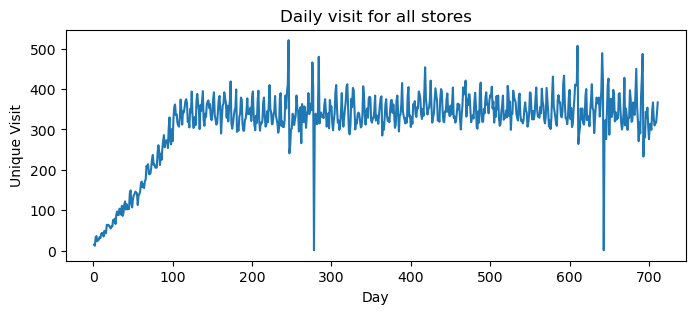

In [9]:
# daily visit pattern union all stores
temp = trx.groupby(day).nunique()[customer_key]
plt.figure(figsize = (8,3))
plt.plot(temp.index, temp)
plt.xlabel('Day')
plt.ylabel('Unique Visit')
plt.title('Daily visit for all stores')

Observations 1:

It seems that the retailers are in the starting stage during the first 100 days, when we see a clear increasing pattern of the customer size. Since we do not plan to model new customer acquisition, **we may consider dropping all transaction records before day 100**. 

Observation 2:

There are also two major drops of daily visit around day 280 and day 630. We may need closer look to these two drops and inspect if there's any suspicious demand changes when modeling the demand curve.

Text(0.5, 0.98, 'Daily statistic summary of all stores')

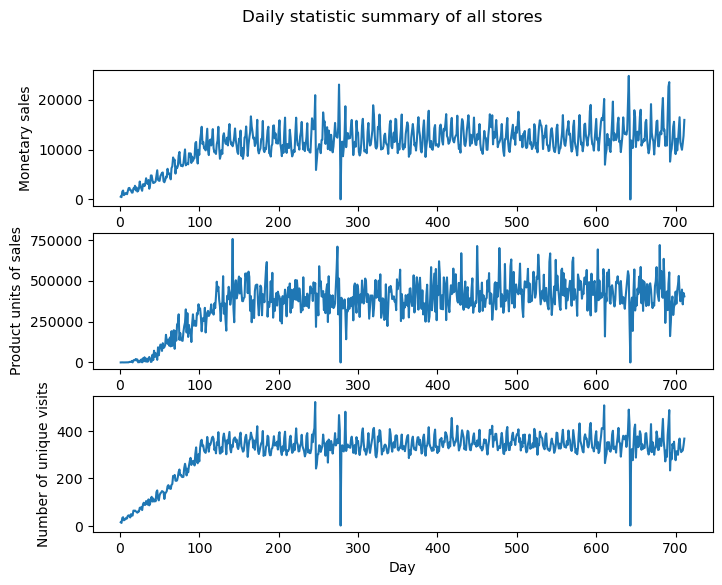

In [10]:
temp = trx.groupby(day).agg({sales_amt: 'sum', item_qty: 'sum', customer_key: 'nunique'})
f, axes = plt.subplots(3, 1, figsize=(8,6))
axes[0].plot(temp.index, temp[sales_amt])
axes[0].set_ylabel('Monetary sales')
axes[1].plot(temp.index, temp[item_qty])
axes[1].set_ylabel('Product units of sales')
axes[2].plot(temp.index, temp[customer_key])
axes[2].set_ylabel('Number of unique visits')
axes[2].set_xlabel('Day')
f.suptitle('Daily statistic summary of all stores')


### 3. Get a list of infrequent customers

In [11]:
# filter out customers who only purchase once or twice
trx.groupby(customer_key).nunique()[day].describe(percentiles = [0.005, 0.01, 0.02, 0.03, 0.1])

count    2500.000000
mean       90.213200
std        76.317337
min         1.000000
0.5%        3.000000
1%          4.000000
2%          6.000000
3%          7.970000
10%        17.000000
50%        70.000000
max       521.000000
Name: DAY, dtype: float64

We will filter out the transactions made by customers who visit less than 3 times (0.5% quantiles). We do not want to include customers who only visited once, because they are essentially inactive customers whom we will not build demand forecasting model for.

In [12]:
threshold = 0.005
temp = trx.groupby(customer_key).nunique()[day]
quantiles = temp.quantile(threshold)
customer_list = temp[temp > quantiles].index

In [13]:
len(customer_list)

2479

### 4. Get a list of infrequent products

In [14]:
# filter out small products that haven't been only purchase once or twice
trx.groupby(product_nbr).nunique()[day].describe(percentiles = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

count    92339.000000
mean        20.012931
std         52.369538
min          1.000000
30%          1.000000
40%          2.000000
50%          3.000000
60%          4.000000
70%          9.000000
80%         19.000000
90%         53.000000
max        708.000000
Name: DAY, dtype: float64

We will filter out the transactions made on products that only have transaction records from less than 4 days (60% quantiles). If a product have scarse data point, we can not even fit a demand curve using a time series based model.

In [15]:
threshold = 0.6
temp = trx.groupby(product_nbr).nunique()[day]
quantiles = temp.quantile(threshold)
frequent_product_list = temp[temp > quantiles].index

### 5. Get a list of products with quite small sales in units

In [16]:
# We will filter out th transactions made on products that have small daily sales
temp = trx.groupby([product_nbr, day]).sum()[item_qty].reset_index()
temp.groupby(product_nbr).mean()[item_qty].describe(percentiles = [0.7, 0.9, 0.95, 0.995])

count     92339.000000
mean          8.662876
std        1064.857216
min           0.000000
50%           1.000000
70%           1.173913
90%           1.800000
95%           2.000000
99.5%         4.706145
max      313360.573082
Name: QUANTITY, dtype: float64

We will filter out the transactions made on products that only have daily sales less than 5 units (99.5% quantiles). If a product has low daily sales, the demand forecasting is almost like a random guess. In this case, the model captures more about the purchase decision rather than relationship between price and demand.

In [17]:
threshold = 0.995
temp = trx.groupby([product_nbr, day]).sum()[item_qty].reset_index()
temp = temp.groupby(product_nbr).mean()[item_qty]
quantiles = temp.quantile(threshold)
big_product_list = temp[temp > quantiles].index

In [18]:
# find union between two filters on product
product_list = set(frequent_product_list) & set(big_product_list)
len(product_list)

203

### 6. filter all dataset used in the model fitting


In [19]:
trx_filtered = trx[(trx[product_nbr].isin(product_list)) & (trx[customer_key].isin(customer_list))]
customer = customer_table[customer_table[customer_key].isin(customer_list)]
product = product_table[product_table[product_nbr].isin(product_list)]

In [20]:
print(f'The transaction dataset has been shrinked to {trx_filtered.shape[0] / trx.shape[0] * 100:.2f}% of the original size')
print(f'The products dataset has been shrinked to {product.shape[0] / product_table.shape[0] * 100:.2f}% of the original size')

The transaction dataset has been shrinked to 13.72% of the original size
The products dataset has been shrinked to 0.22% of the original size


The filtered transaction dataset is in a good size that we decide not to proceed to select a specific department.

### 7. Compute the base price and discount for the transaction table

In [21]:
discount_cols = ['RETAIL_DISC', 'COUPON_DISC', 'COUPON_MATCH_DISC']
trx_filtered.loc[:, base_price] = (trx_filtered[sales_amt] - trx_filtered[discount_cols].sum(axis=1)) / trx_filtered[item_qty]
trx_filtered.loc[:, discount_portion] = 1 - trx_filtered[sales_amt] / trx_filtered[base_price]

/var/folders/4_/hbrj9kqj3sn9lwnrjfqfn95rj_1g25/T/ipykernel_66446/1307522301.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trx_filtered.loc[:, base_price] = (trx_filtered[sales_amt] - trx_filtered[discount_cols].sum(axis=1)) / trx_filtered[item_qty]
/var/folders/4_/hbrj9kqj3sn9lwnrjfqfn95rj_1g25/T/ipykernel_66446/1307522301.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trx_filtered.loc[:, discount_portion] = 1 - trx_filtered[sales_amt] / trx_filtered[base_price]


In [22]:
trx_filtered.head(2)

,household_key,BASKET_ID,DAY,PRODUCT_ID,QUANTITY,SALES_VALUE,STORE_ID,RETAIL_DISC,TRANS_TIME,WEEK_NO,COUPON_DISC,COUPON_MATCH_DISC,Base_Price,Discount_Portion
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0,1.99,0.301508
3,2375,26984851472,1,1082185,1,1.21,364,0.0,1631,1,0.0,0.0,1.21,0.000000


In [110]:
trx_filtered.to_csv(data_path + 'transaction_filtered.csv', index=False)
customer.to_csv(data_path + 'customer_filtered.csv', index=False)
product.to_csv(data_path + 'product_filtered.csv', index=False)

### 8. Understand the product hierarchy table
We should not narrow down our focus to a specific department, because all department can be categorized as "grocery-related" that do not necessarily drive the customer loyalty. Rather than choosing one department, we'd better keep all of them.

In [23]:
product['DEPARTMENT'].unique()

array(['PRODUCE', 'GROCERY', 'KIOSK-GAS', 'MISC SALES TRAN', 'DRUG GM',
       'MEAT', 'PASTRY', 'NUTRITION', 'MEAT-PCKGD', 'DELI',
       'TRAVEL & LEISUR', 'SALAD BAR', 'MISC. TRANS.', 'FROZEN GROCERY',
       'FLORAL'], dtype=object)

### Notes
1. The customer table does not have the full record of all customers in the transaction record. We should not use the customer table for any inference purposes.

In [24]:
# number of unique customer id in the transaction dataset
trx[customer_key].nunique()

2500

In [25]:
# number of unique customer id in the customer dataset
customer_table[customer_key].nunique()

801

In [95]:
# query the length of the customer list
len(customer_list)

2438

2. The product table does not have the full record of all products in the transaction record

In [26]:
trx[product_nbr].nunique()

92339

In [27]:
product_table[product_nbr].nunique()

92353

In [28]:
product.columns

Index(['PRODUCT_ID', 'MANUFACTURER', 'DEPARTMENT', 'BRAND', 'COMMODITY_DESC',
       'SUB_COMMODITY_DESC', 'CURR_SIZE_OF_PRODUCT'],
      dtype='object')